In [13]:
import geopandas as gpd

mainLink='https://github.com/DACSS-CSSmeths/Spatial-Exploring/raw/refs/heads/main/maps/countriesCIA.gpkg'
mapsLink=mainLink+'maps/worldMaps_Py.gpkg'

gpd.list_layers(mainLink)

cia=gpd.read_file(mainLink, layer='cia')
cia.head()

,COUNTRY,name,region,obesityAdults_rate,TobaccoUse_perc,Alcohol_LitersPerCap,tobacco_code,tobacco_levels,tobacco_custom,alcohol_code,alcohol_levels,geometry
0,Afghanistan,Afghanistan,South Asia,5.5,23.3,0.01,2,3.average,3.(15-30],0,1.very low,"MULTIPOLYGON (((61.277 35.607, 61.296 35.629, ..."
1,Algeria,Algeria,Africa,27.4,21.0,0.59,2,3.average,3.(15-30],0,1.very low,"MULTIPOLYGON (((-5.1521 30.18, -5.1392 30.192,..."
2,Azerbaijan,Azerbaijan,Middle East,19.9,24.0,1.38,2,3.average,3.(15-30],0,1.very low,"MULTIPOLYGON (((46.54 38.876, 46.496 38.957, 4..."
3,Albania,Albania,Europe,21.7,22.4,4.40,2,3.average,3.(15-30],2,3.average,"MULTIPOLYGON (((20.792 40.432, 20.787 40.395, ..."
4,Armenia,Armenia,Middle East,20.2,25.5,3.77,2,3.average,3.(15-30],1,2.low,"MULTIPOLYGON (((46.54 38.876, 46.516 38.878, 4..."


In [15]:
!pip install mapclassify
import mapclassify

In [16]:
import numpy as np

np.random.seed(12345)

K=5
theVar=cia.obesityAdults_rate


# same interval width, easy interpretation
ei5 = mapclassify.EqualInterval(theVar, k=K)
# same interval width based on standard deviation, easy - but not as the previous one, poor when high skewness
msd = mapclassify.StdMean(theVar)
# interval width varies, counts per interval are close, not easy to grasp, repeated values complicate cuts
q5=mapclassify.Quantiles(theVar,k=K)
# based on similarity, good for multimodal data
mb5 = mapclassify.MaximumBreaks(theVar, k=K)
# based on similarity, optimizer
fj5 = mapclassify.FisherJenks(theVar, k=K)
# based on similarity, optimizer
jc5 = mapclassify.JenksCaspall(theVar, k=K)
# based on similarity, optimizer
mp5 = mapclassify.MaxP(theVar, k=K)

###### based on similarity, good for skewed data
ht = mapclassify.HeadTailBreaks(theVar)

In [19]:
import pandas as pd

class5 = ei5,msd, q5,mb5,  ht, fj5, jc5, mp5
# Collect ADCM for each classifier
fits = np.array([ c.adcm for c in class5])
# Convert ADCM scores to a DataFrame
adcms = pd.DataFrame(fits)
# Add classifier names
adcms['classifier'] = [c.name for c in class5]
# Add column names to the ADCM
adcms.columns = ['ADCM', 'Classifier']

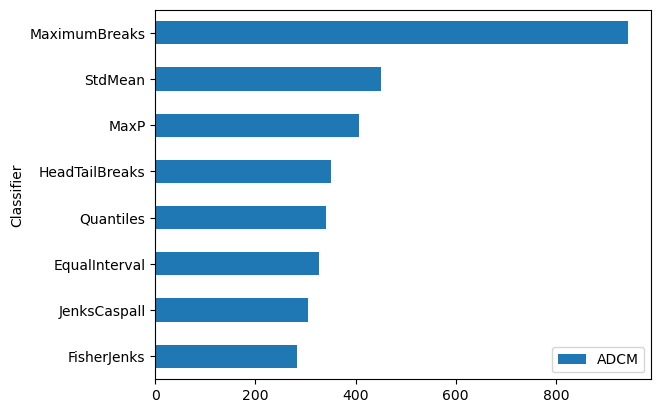

In [21]:
import matplotlib.pyplot as plt
adcms.sort_values('ADCM').plot.barh(x='Classifier')
plt.show();

In [23]:
fj5.yb

array([0, 2, 1, 1, 1, 2, 2, 2, 1, 3, 2, 1, 1, 0, 2, 1, 1, 0, 2, 1, 1, 2,
       1, 0, 2, 0, 0, 0, 0, 2, 0, 0, 1, 2, 2, 1, 1, 2, 1, 3, 2, 1, 0, 2,
       0, 1, 3, 1, 1, 0, 1, 2, 1, 1, 1, 2, 2, 1, 0, 2, 2, 1, 3, 0, 2, 3,
       0, 1, 4, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1, 0, 1, 1, 0, 0, 2, 0, 0, 2,
       2, 0, 2, 2, 1, 0, 0, 2, 0, 1, 2, 0, 4, 3, 1, 1, 0, 2, 1, 1, 1, 0,
       3, 1, 0, 2, 0, 3, 1, 2, 0, 1, 0, 0, 2, 1, 1, 1, 0, 4, 0, 0, 2, 4,
       1, 0, 0, 2, 2, 3, 0, 2, 1, 0, 1, 1, 0, 1, 0])

In [25]:
cia['obesity_code']=fj5.yb

cia=cia.assign(obesity_levels=cia.obesity_code)

In [27]:
newLevels={0:'1.very low',1:'2.low', 2:'3.average',3:'4.high', 4:'5.very high'}

cia.replace({'obesity_levels':newLevels}, inplace=True)

cia.obesity_levels.value_counts()

obesity_levels
2.low          50
1.very low     44
3.average      38
4.high         11
5.very high     4
Name: count, dtype: int64

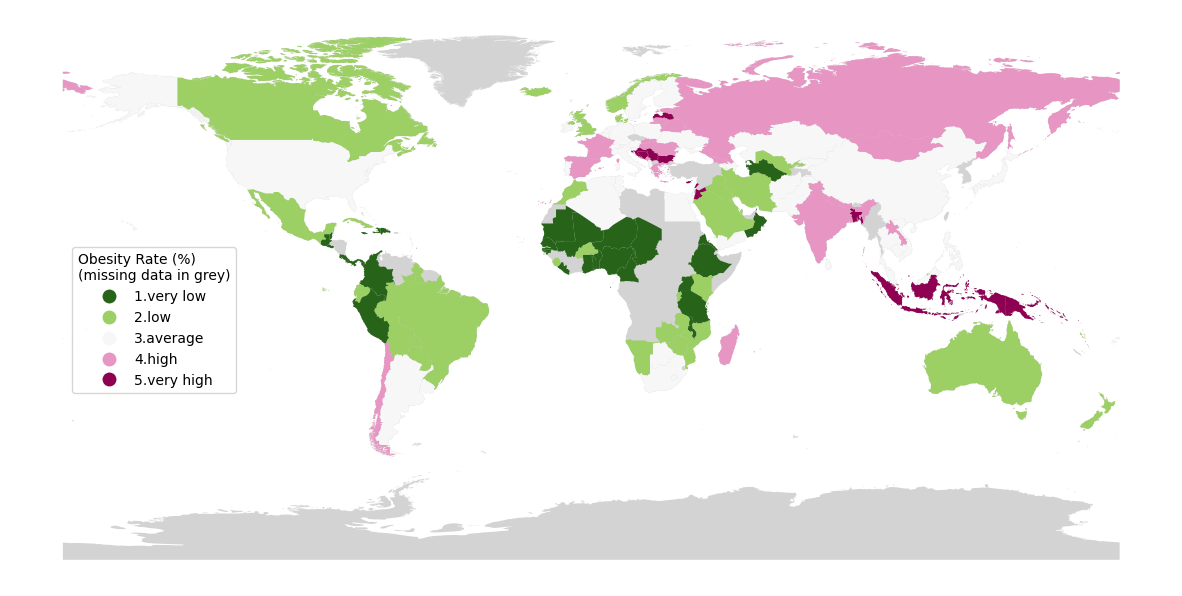

In [29]:
countries=gpd.read_file(mainLink, layer='border')
worldBorders=countries.dissolve()
base=worldBorders.plot(color='lightgrey',
                     figsize=(15, 10))
cia.plot(column='tobacco_levels',ax=base,
                     cmap='PiYG_r', # reversed
                     categorical=True,
                     linewidth=0.,
                     legend=True,
                     legend_kwds={"title": "Obesity Rate (%)\n(missing data in grey)"}
                   )
base.set_axis_off()

# locating the legend
leg = base.get_legend()
leg.set_bbox_to_anchor((0.2, 0.6)) 

plt.show();

In [30]:
topcountries=cia[(cia.tobacco_code==0) & (cia.alcohol_code==0) & (cia.obesity_code==0)]
topcountries

,COUNTRY,name,region,obesityAdults_rate,TobaccoUse_perc,Alcohol_LitersPerCap,tobacco_code,tobacco_levels,tobacco_custom,alcohol_code,alcohol_levels,geometry,obesity_code,obesity_levels
17,Benin,Benin,Africa,9.6,6.9,1.25,0,1.very low,2.(5-15],0,1.very low,"MULTIPOLYGON (((2.733 7.6582, 2.7322 7.6519, 2...",0,1.very low
26,Chad,Chad,Africa,6.1,8.3,0.55,0,1.very low,2.(5-15],0,1.very low,"MULTIPOLYGON (((14.195 9.9818, 14.451 9.9981, ...",0,1.very low
42,Eritrea,Eritrea,Africa,5.0,7.5,0.93,0,1.very low,2.(5-15],0,1.very low,"MULTIPOLYGON (((42.068 13.698, 42.09 13.678, 4...",0,1.very low
44,Ethiopia,Ethiopia,Africa,4.5,5.1,1.16,0,1.very low,2.(5-15],0,1.very low,"MULTIPOLYGON (((45.489 5.4898, 45.374 5.3639, ...",0,1.very low
49,Ghana,Ghana,Africa,10.9,3.5,1.59,0,1.very low,1. below5,0,1.very low,"MULTIPOLYGON (((0.32238 6.0358, 0.35375 6.0233...",0,1.very low
83,Mali,Mali,Africa,8.6,8.3,0.60,0,1.very low,2.(5-15],0,1.very low,"MULTIPOLYGON (((-9.8652 12.055, -9.9119 12.093...",0,1.very low
86,Mauritania,Mauritania,Africa,12.7,10.7,0.00,0,1.very low,2.(5-15],0,1.very low,"MULTIPOLYGON (((-6.336 22.99, -6.3258 22.906, ...",0,1.very low
94,Niger,Niger,Africa,5.5,7.4,0.11,0,1.very low,2.(5-15],0,1.very low,"MULTIPOLYGON (((7.0281 12.996, 6.9422 12.997, ...",0,1.very low
118,Senegal,Senegal,Africa,8.8,6.9,0.25,0,1.very low,2.(5-15],0,1.very low,"MULTIPOLYGON (((-14.342 12.679, -14.393 12.679...",0,1.very low
128,Togo,Togo,Africa,8.4,6.8,1.40,0,1.very low,2.(5-15],0,1.very low,"MULTIPOLYGON (((1.6554 7.5298, 1.6501 7.5139, ...",0,1.very low


In [31]:
cia.info()
###UNABLE TO SAVE OVER LAYERS AS SEEN IN LINE 57 OF TUTORIAL
###GIVES ERRROR UNABLE TO ACCESS DATABASE

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   COUNTRY               147 non-null    object  
 1   name                  147 non-null    object  
 2   region                147 non-null    object  
 3   obesityAdults_rate    147 non-null    float64 
 4   TobaccoUse_perc       147 non-null    float64 
 5   Alcohol_LitersPerCap  147 non-null    float64 
 6   tobacco_code          147 non-null    int64   
 7   tobacco_levels        147 non-null    object  
 8   tobacco_custom        147 non-null    object  
 9   alcohol_code          147 non-null    int64   
 10  alcohol_levels        147 non-null    object  
 11  geometry              147 non-null    geometry
 12  obesity_code          147 non-null    int64   
 13  obesity_levels        147 non-null    object  
dtypes: float64(3), geometry(1), int64(3), object(7)
me